# Dataset statistics

In [1]:
import torch

def compute_mean_std(loader):
    mean = 0.
    meansq = 0.
    for data, _ in loader:
        mean = data.mean()
        meansq = (data**2).mean()
    std = torch.sqrt(meansq - mean**2)
    return mean.item(), std.item()


In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

lesion_image_dir = './data/scan-severity/train'
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
dataset = ImageFolder(lesion_image_dir, transform=transform)
scan_train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

roi_syn_image_dir = './data/roi-severity_synthetized/train'
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
dataset = ImageFolder(roi_syn_image_dir, transform=transform)
roi_syn_train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [12]:
mean, std = compute_mean_std(scan_train_loader)
print(f"{lesion_image_dir} - Mean: {mean}, Std: {std}")

mean, std = compute_mean_std(roi_syn_train_loader)
print(f"{roi_syn_image_dir} - Mean: {mean}, Std: {std}")

./data/scan-severity/train - Mean: 0.2095540165901184, Std: 0.2696904242038727
./data/roi-severity_synthetized/train - Mean: 0.5457635521888733, Std: 0.16353686153888702


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

scan_synthetized_image_dir = './data/scan-severity_synthetized/train'
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder(scan_synthetized_image_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean, std = compute_mean_std(train_loader)
print(f"{scan_synthetized_image_dir} - Mean: {mean}, Std: {std}")

./data/scan-severity_synthetized/train - Mean: 0.22336362302303314, Std: 0.27230104804039


## Dataset augmentations

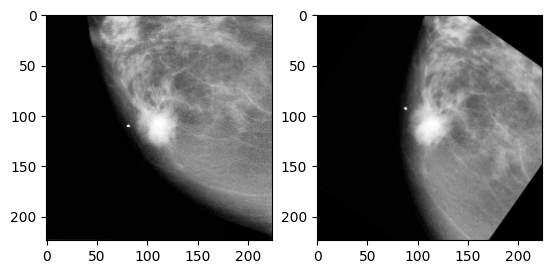

In [17]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

def augment_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    augmented = augmentation_pipeline(image=image)['image']
    return image, augmented

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, always_apply=True, border_mode=cv2.BORDER_CONSTANT, p=1.0),
])

test_image = './figures/mass_malignant_sample.png'
original_image, augmented_image = augment_image(test_image)

f, axarr = plt.subplots(1,2)

axarr[0].imshow(original_image, cmap='gray')
axarr[1].imshow(augmented_image, cmap='gray')

plt.show()

## Patch Extraction

In [1]:
import pandas as pd
from src.utils.dicom import load_dicom_image, load_dicom_mask
from src.utils.crop import extract_patch
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

resize = 128
patch_padding = 100
data_dir = "/mnt/d/datasets/CBIS/data"
calc_train_csv = data_dir + '/mass_case_description_train_set_corrected.csv'
df = pd.read_csv(calc_train_csv)
row = df.iloc[10]


sample_path = row['image_file_path']
mask_file_path = row['roi_mask_file_path']

image_path = os.path.join(data_dir, sample_path)
image = load_dicom_image(glob(image_path + '/*.dcm')[0])
mask_path = glob(os.path.join(data_dir, mask_file_path, '*.dcm'))
mask = load_dicom_mask(mask_path, image.shape)

### Image enhancement


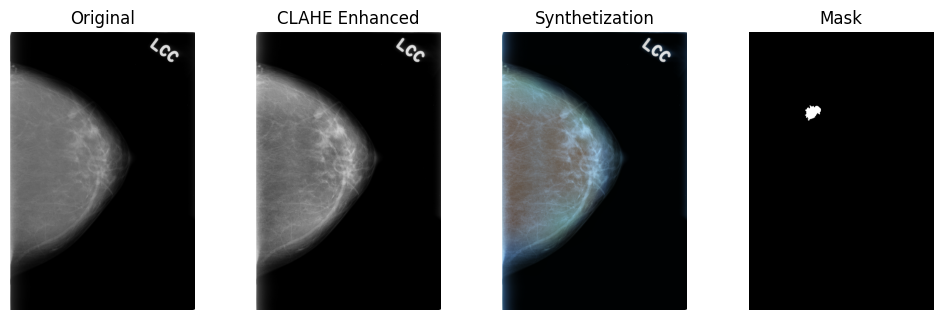

In [2]:
import cv2

def clahe(img, clip = 1.5):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(img)
    return cl

clahe_image = clahe(image, 1.0)
clahe_image_2 = clahe(image, 2.0)
synthetized = cv2.merge((image, clahe_image, clahe_image_2))

f, axarr = plt.subplots(1,4)
f.set_size_inches(10, 10)
f.tight_layout()
axarr[0].imshow(image, cmap='gray')
axarr[0].set_title('Original')
axarr[0].axis('off')
axarr[1].imshow(clahe_image, cmap='gray')
axarr[1].set_title('CLAHE Enhanced')
axarr[1].axis('off')
axarr[2].imshow(synthetized, cmap='gray')
axarr[2].set_title('Synthetization')
axarr[2].axis('off')
axarr[3].imshow(mask,cmap='gray')
axarr[3].set_title('Mask')
axarr[3].axis('off')
plt.show()

### Patch visualization

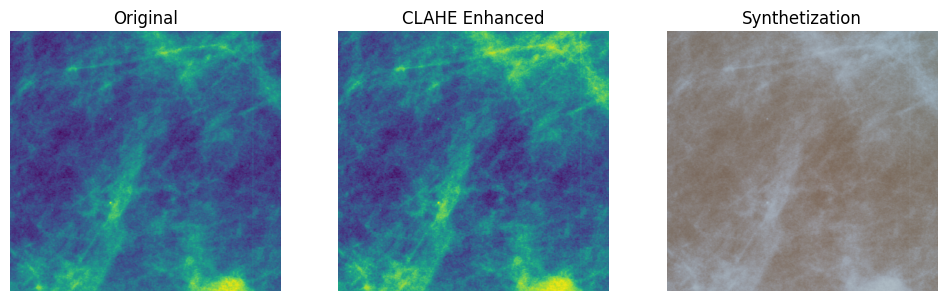

In [4]:
patch = extract_patch(image, mask, 200)
clahe_patch = extract_patch(clahe_image, mask, 200)
synthetized_patch = extract_patch(synthetized, mask, 200)

f, axarr = plt.subplots(1, 3)
f.set_size_inches(10, 10)
f.tight_layout()
axarr[0].imshow(patch)
axarr[0].set_title('Original')
axarr[0].axis('off')
axarr[1].imshow(clahe_patch)
axarr[1].set_title('CLAHE Enhanced')
axarr[1].axis('off')
axarr[2].imshow(synthetized_patch)
axarr[2].set_title('Synthetization')
axarr[2].axis('off')
plt.show()

In [100]:
import cv2

image = load_dicom_image(glob(image_path + '/*.dcm')[0])
image = cv2.merge((image, clahe(image, 1.0), clahe(image, 2.0)))
patch = extract_patch(image, mask, 200)

resized_patch = cv2.resize(
    patch,
    (128, 128),
    interpolation=cv2.INTER_LINEAR
)
cv2.imwrite('./test.png', patch)


True